In [37]:
import pandas                  as     pd
import numpy                   as     np
import seaborn                 as     sns
from sklearn.model_selection   import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn                   import datasets
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.datasets          import load_iris
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot       as     plt
from sklearn.preprocessing     import StandardScaler


from sklearn.svm               import SVC
from sklearn.linear_model      import LinearRegression
import warnings
warnings.filterwarnings("ignore")

#datasets.load*?

In [38]:
def sklearn_to_df(sklearn_dataset):
    df            = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target']  = pd.Series(sklearn_dataset.target)
    return df

In [39]:
df = sklearn_to_df(datasets.load_wine())
X = df.drop('target', axis = 1)
y = df['target']

In [40]:
def plot_res(efs):
    metric_dict    = efs.get_metric_dict()

    fig            = plt.figure()
    k_feat         = sorted(metric_dict.keys())
    avg            = [metric_dict[k]['avg_score'] for k in k_feat]

    upper, lower   = [], []
    for k in k_feat:
        upper.append(metric_dict[k]['avg_score'] +
                     metric_dict[k]['std_dev'])
        lower.append(metric_dict[k]['avg_score'] -
                     metric_dict[k]['std_dev'])

    plt.fill_between(k_feat,
                     upper,
                     lower,
                     alpha=0.2,
                     color='blue',
                     lw=1)

    plt.plot(k_feat, avg, color='blue', marker='o');
    plt.ylabel('Accuracy +/- Standard Deviation')
    plt.xlabel('Number of Features')
    feature_min = len(metric_dict[k_feat[0]]['feature_idx'])
    feature_max = len(metric_dict[k_feat[-1]]['feature_idx'])
    plt.xticks(k_feat, 
               [str(metric_dict[k]['feature_names']) for k in k_feat], 
               rotation=90);
    plt.show();

In [41]:
std      = StandardScaler()
X_scaled = std.fit_transform(X)
X        = pd.DataFrame(X_scaled, columns = X.columns)

print(X.shape)
X.head(5)

(178, 13)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


## Correlation

In [42]:
df_corr = df.corr()

def highlight_range(s):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = s == s.max()
    threshold = 0.75
    val = np.abs(s) > threshold
    return ['background-color: lightgreen' if v else '' for v in val]

df_corr.style.apply(highlight_range).set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720,-0.328222
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011,0.437776
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626,-0.049643
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597,0.517859
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351,-0.209179
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115,-0.719163
flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193,-0.847498
nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385,0.489109
proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417,-0.499130
color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100,0.265668


In [43]:
df       = df.drop(['flavanoids','od280/od315_of_diluted_wines'], axis = 1)
X        = df.drop('target', axis = 1)
y        = df['target']
std      = StandardScaler()
X_scaled = std.fit_transform(X)
X        = pd.DataFrame(X_scaled, columns = X.columns)

print(X.shape)
X.head(5)

(178, 11)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,-0.659563,1.224884,0.251717,0.362177,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,-0.820719,-0.544721,-0.293321,0.406051,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,-0.498407,2.135968,0.269020,0.318304,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,-0.981875,1.032155,1.186068,-0.427544,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.226796,0.401404,-0.319276,0.362177,-0.037874


In [44]:
df_corr = df.corr()

def highlight_range(s):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = s == s.max()
    threshold = 0.75
    val = np.abs(s) > threshold
    return ['background-color: lightgreen' if v else '' for v in val]

df_corr.style.apply(highlight_range).set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,proline,target
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,-0.155929,0.136698,0.546364,-0.071747,0.643720,-0.328222
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,0.292977,-0.220746,0.248985,-0.561296,-0.192011,0.437776
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.186230,0.009652,0.258887,-0.074667,0.223626,-0.049643
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,0.361922,-0.197327,0.018732,-0.273955,-0.440597,0.517859
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,-0.256294,0.236441,0.199950,0.055398,0.393351,-0.209179
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,-0.449935,0.612413,-0.055136,0.433681,0.498115,-0.719163
nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,1.000000,-0.365845,0.139057,-0.262640,-0.311385,0.489109
proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,-0.365845,1.000000,-0.025250,0.295544,0.330417,-0.499130
color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,0.139057,-0.025250,1.000000,-0.521813,0.316100,0.265668
hue,-0.071747,-0.561296,-0.074667,-0.273955,0.055398,0.433681,-0.262640,0.295544,-0.521813,1.000000,0.236183,-0.617369


## Exhaustive Feature Selection

In [45]:
model_reg  = LinearRegression()
fwd_reg    = SFS(model_reg, k_features=5,    forward=True,             scoring='r2',        verbose=2,             cv=4)
bwd_reg    = SFS(model_reg, k_features=5,    forward=False,            scoring='r2',        verbose=2,             cv=4)
efs_reg    = EFS(model_reg, min_features=2,  max_features=X.shape[1],  scoring='r2',        print_progress=True,   cv=4)

In [46]:
model_clf  = KNeighborsClassifier(n_neighbors=3)
fwd_clf    = SFS(model_clf, k_features=X.shape[1],    forward=True,             scoring='accuracy',        verbose=2,             cv=4)
bwd_clf    = SFS(model_clf, k_features=X.shape[1],    forward=False,            scoring='accuracy',        verbose=2,             cv=4)
efs_clf    = EFS(model_clf, min_features=1,           max_features=X.shape[1],  scoring='accuracy',        print_progress=True,   cv=4)

In [47]:
%%time
efs            = efs_clf.fit(X, y, custom_feature_names=X.columns)

print('Best accuracy score: %.2f'           % efs.best_score_)
print('Best subset (corresponding names):', efs.best_feature_names_)

res = pd.DataFrame.from_dict(efs.get_metric_dict()).T
res.sort_values('avg_score', inplace=True, ascending=False)

#res[['feature_names','avg_score']]

#plot_res(efs)

Features: 2047/2047

Best accuracy score: 0.97
Best subset (corresponding names): ('alcohol', 'alcalinity_of_ash', 'nonflavanoid_phenols', 'proanthocyanins', 'hue', 'proline')
CPU times: user 25.7 s, sys: 304 ms, total: 26 s
Wall time: 25.8 s


In [63]:
#res[['feature_names','avg_score']]
df_concat = pd.concat([df[np.asarray(efs.best_feature_names_)],df['target']],axis = 1)
df_concat.corr()['target']

alcohol                -0.328222
alcalinity_of_ash       0.517859
nonflavanoid_phenols    0.489109
proanthocyanins        -0.499130
hue                    -0.617369
proline                -0.633717
target                  1.000000
Name: target, dtype: float64

In [75]:
df_concat.to_pickle('output/load_wine/03 Feature_Selection_load_wine')

## Backward / Forward Feature Selection

In [66]:
#fwd_clf    = SFS(model_clf, k_features=9,    forward=True,             scoring='accuracy',        verbose=2,             cv=4)
efs            = fwd_clf.fit(X, y, custom_feature_names=X.columns)
filtered_features= X.columns[list(efs.k_feature_idx_)]
filtered_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished

[2020-07-15 10:46:57] Features: 1/11 -- score: 0.6806818181818182[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished

[2020-07-15 10:46:57] Features: 2/11 -- score: 0.9162878787878789[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished

[2020-07-15 10:46:57] Features: 3/11 -- score: 0.9387626262626263[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'nonflavanoid_phenols', 'proanthocyanins',
       'color_intensity', 'hue', 'proline'],
      dtype='object')

## XG Boost - Feature Importance

#### Regression

Feature: 0, Score: 0.00567
Feature: 1, Score: 0.00572
Feature: 2, Score: 0.00140
Feature: 3, Score: 0.00139
Feature: 4, Score: 0.00024
Feature: 5, Score: 0.38262
Feature: 6, Score: 0.00045
Feature: 7, Score: 0.00072
Feature: 8, Score: 0.08733
Feature: 9, Score: 0.14302
Feature: 10, Score: 0.37144


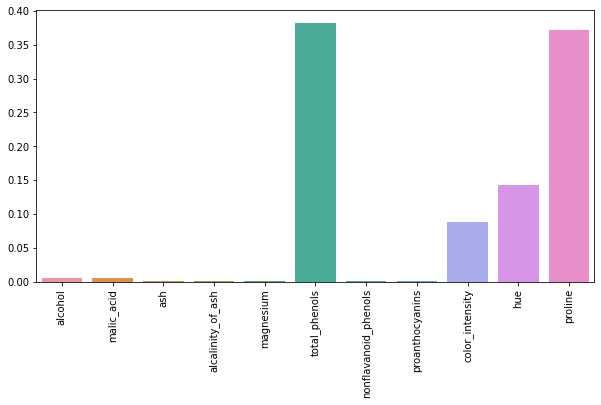

In [67]:
# xgboost for feature importance on a regression problem
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
import seaborn as sns
# define dataset
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = XGBRegressor()
# fit the model
model.fit(X, y);
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#pyplot.bar([x for x in range(len(importance))], importance)
fig, axes = plt.subplots(figsize = (10,5))
sns.barplot(X.columns, importance, ax = axes)
plt.xticks(rotation = 90)
plt.show()

#### Classifier

Feature: 0, Score: 0.00567
Feature: 1, Score: 0.00572
Feature: 2, Score: 0.00140
Feature: 3, Score: 0.00139
Feature: 4, Score: 0.00024
Feature: 5, Score: 0.38262
Feature: 6, Score: 0.00045
Feature: 7, Score: 0.00072
Feature: 8, Score: 0.08733
Feature: 9, Score: 0.14302
Feature: 10, Score: 0.37144


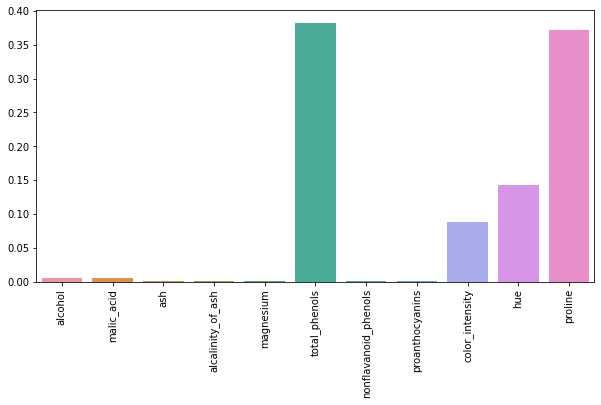

In [68]:
# xgboost for feature importance on a regression problem
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from matplotlib import pyplot
# define dataset
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = XGBRegressor()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, axes = plt.subplots(figsize = (10,5))
sns.barplot(X.columns, importance, ax = axes)
plt.xticks(rotation = 90)
plt.show()

## Random Forest 

#### Regression

Feature: 0, Score: 0.02890
Feature: 1, Score: 0.01279
Feature: 2, Score: 0.00506
Feature: 3, Score: 0.00629
Feature: 4, Score: 0.00521
Feature: 5, Score: 0.18430
Feature: 6, Score: 0.00368
Feature: 7, Score: 0.01244
Feature: 8, Score: 0.11638
Feature: 9, Score: 0.21718
Feature: 10, Score: 0.40777


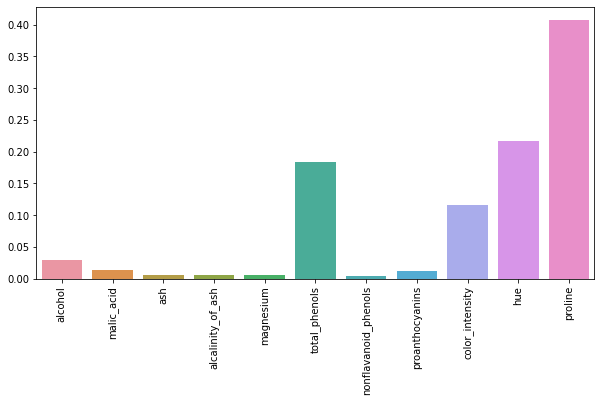

In [69]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define dataset
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = RandomForestRegressor()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, axes = plt.subplots(figsize = (10,5))
sns.barplot(X.columns, importance, ax = axes)
plt.xticks(rotation = 90)
plt.show()

#### Classification

Feature: 0, Score: 0.02844
Feature: 1, Score: 0.01269
Feature: 2, Score: 0.00389
Feature: 3, Score: 0.00815
Feature: 4, Score: 0.00818
Feature: 5, Score: 0.18946
Feature: 6, Score: 0.00218
Feature: 7, Score: 0.01467
Feature: 8, Score: 0.13238
Feature: 9, Score: 0.20287
Feature: 10, Score: 0.39708


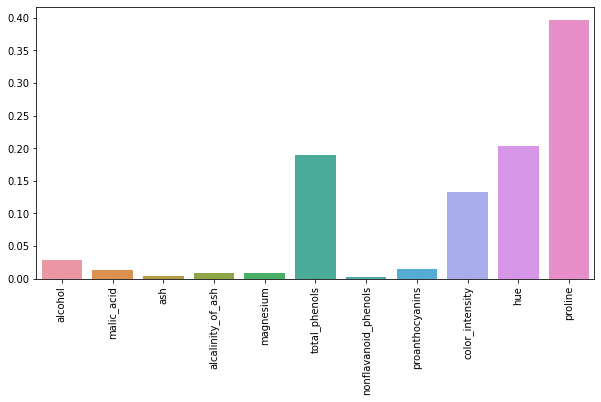

In [70]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define dataset
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = RandomForestRegressor()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, axes = plt.subplots(figsize = (10,5))
sns.barplot(X.columns, importance, ax = axes)
plt.xticks(rotation = 90)
plt.show()

## Permutation

#### Regression

Feature: 0, Score: 0.02589
Feature: 1, Score: 0.00184
Feature: 2, Score: 0.00355
Feature: 3, Score: 0.00818
Feature: 4, Score: 0.00211
Feature: 5, Score: 0.03533
Feature: 6, Score: 0.01142
Feature: 7, Score: 0.02184
Feature: 8, Score: 0.03658
Feature: 9, Score: 0.01811
Feature: 10, Score: 0.04360


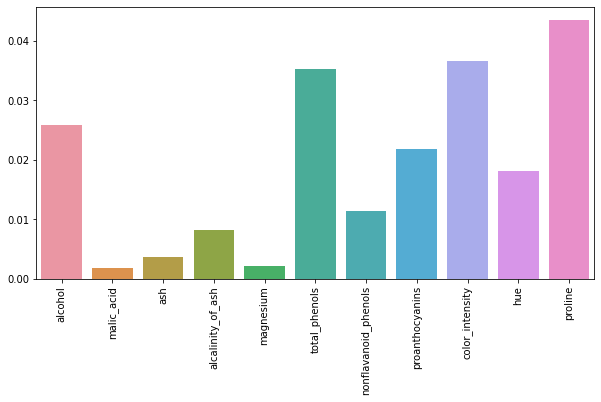

In [71]:
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# define dataset
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = KNeighborsRegressor()
# fit the model
model.fit(X, y)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, axes = plt.subplots(figsize = (10,5))
sns.barplot(X.columns, importance, ax = axes)
plt.xticks(rotation = 90)
plt.show()

#### Classifier

Feature: 0, Score: 0.04944
Feature: 1, Score: 0.00337
Feature: 2, Score: 0.00562
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00225
Feature: 5, Score: -0.00112
Feature: 6, Score: 0.00899
Feature: 7, Score: 0.01461
Feature: 8, Score: 0.04494
Feature: 9, Score: 0.01461
Feature: 10, Score: 0.05730


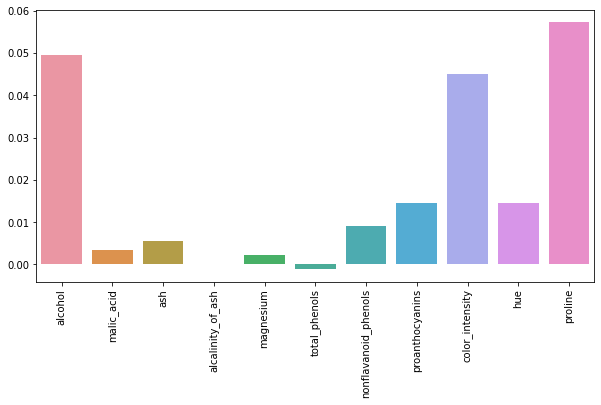

In [72]:
# permutation feature importance with knn for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# define dataset
#X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = KNeighborsClassifier()
# fit the model
model.fit(X, y)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, axes = plt.subplots(figsize = (10,5))
sns.barplot(X.columns, importance, ax = axes)
plt.xticks(rotation = 90)
plt.show()